In [2]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import scipy.stats as st
import random 
from scipy.optimize import curve_fit
import math
import time

%matplotlib inline 

In [3]:
# generate sequence logo
from weblogolib import LogoData, LogoOptions, read_seq_data, LogoFormat, pdf_formatter, std_color_schemes
import weblogolib
from wand.image import Image as WImage
import os
def printWebLogo(array_seqs, title, logofilename = "logo.pdf", xaxislabel = "", units = "probability"):
    #inputs:
        #array_seqs = list 
        #title of chart
        #units = probability or bits 
    seqFASTA = open("sequences.fasta", "w")
    for aa_seq in array_seqs:
        seqFASTA.write(aa_seq[5:]+"-"+aa_seq[:5]+"\n")
    seqFASTA.close()
    data  = LogoData.from_seqs(read_seq_data(open("sequences.fasta", "r")))
    options = LogoOptions()
    options.logo_title = title
    options.fineprint = xaxislabel
    options.size = 'large'
    options.unit_name = units
    options.color_scheme = weblogolib.std_color_schemes['chemistry']
    Format = LogoFormat(data, options)
    if logofilename == "logo.pdf":
        logofilename = title+".pdf"
    logofile = open(logofilename,'w')
    pdf = pdf_formatter(data, Format)
    logofile.write(pdf)
    logofile.close()
    img = WImage(filename=logofilename, resolution = 250)
    return img

geneticcode = {'ggg':'G', 'gga':'G', 'ggc':'G', 'ggt':'G','gag':'E', 'gaa':'E', 'gac':'D', 'gat':'D','gcg':'A', 'gca':'A', 'gcc':'A', 'gct':'A',
               'gtg':'V', 'gta':'V', 'gtc':'V', 'gtt':'V','agg':'R', 'aga':'R', 'agc':'S', 'agt':'S','aag':'K', 'aaa':'K', 'aac':'N', 'aat':'N',
               'acg':'T', 'aca':'T', 'acc':'T', 'act':'T','atg':'M', 'ata':'I', 'atc':'I', 'att':'I','cgg':'R', 'cga':'R', 'cgc':'R', 'cgt':'R',
               'cag':'Q', 'caa':'Q', 'cac':'H', 'cat':'H','ccg':'P', 'cca':'P', 'ccc':'P', 'cct':'P','ctg':'L', 'cta':'L', 'ctc':'L', 'ctt':'L',
               'tgg':'W', 'tga':'*', 'tgc':'C', 'tgt':'C','tag':'*', 'taa':'*', 'tac':'Y', 'tat':'Y','tcg':'S', 'tca':'S', 'tcc':'S', 'tct':'S','ttg':'L', 'tta':'L', 'ttc':'F', 'ttt':'F'}

def translateDNA(seq):
    #converts DNA to aa seq
    i = 0
    aa = ""
    while i <= len(seq)-3:
        try:
            aa += geneticcode[seq[i:i+3].lower()]
        except KeyError:
            aa += "X"
        i +=3
    return aa

def find_stop_codon(sequence):
    i = 0
    stops = []
    while i <= len(seq)-3:
        try:
            if "*" == geneticcode[seq[i:i+3].lower()]:
                stops += [seq[i:i+3]]
        except KeyError:
            pass
        i +=3
    return stops

def rev_comp(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A','a': 't', 'c': 'g', 'g': 'c', 't': 'a'}
    return "".join(complement.get(base, base) for base in reversed(seq))

def heatmap(mat, filename = 'heatmap.png', labels = False):
    #inputs:
        #matrix
        #labels = tuple(xlabels, ylabels), both lists
    fig,ax = plt.subplots()
    heatmap = ax.pcolormesh(mat)#,cmap=plt.cm.PRGn)
    # want a more natural, table-like display
    cbar = plt.colorbar(heatmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(mat.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(mat.shape[1]) + 0.5, minor=False)

    ax.invert_yaxis()
#     ax.xaxis.tick_top()
    ax.set_xbound(0,mat.shape[1])
    ax.set_ybound(0,mat.shape[0])
    
    if labels:
        ax.set_xticklabels(labels[0], minor=False)
        ax.set_yticklabels(labels[1], minor=False)
    
    ax.grid(False)
    plt.savefig(filename)
    
blosum62txt = open('BLOSUM62.txt','r')
blosum62dict = {}
initialized = 0
for line in blosum62txt:
    if line[0] == "#": continue
    else:
        if initialized == 0:
            aas = line.split()
            blosum62dict = dict.fromkeys(aas)
            initialized += 1
        else:
            line = line.split()
            blosum62dict[line[0]] = {}
            for i in range(len(line)-1):
                blosum62dict[line[0]][aas[i]] = int(line[i+1])
# print blosum62
            
def blosum62(seq1,seq2):
    #actual blosum scores between two sequences
    if len(seq1) != len(seq2):
        print "mismatched lengths"
        raise
    blosum_score = 0
    for i in range(len(seq1)):
        blosum_score +=  blosum62dict[seq1[i]][seq2[i]]
    return blosum_score

In [4]:
#normalized, thresholded frequencies (of each seq in each bin)
ntfreq = np.load(open("ntfreq.npy","r"))
#dictionary of DNA seq to index 
td2i = pickle.load(open("td2i.pck","r"))
#thresholded counts (of each seq in each bin)
tcounts = np.load(open("tcounts.npy","r"))

In [5]:

#log10(YFP) geo means of the sorted bins:
x1 = np.array([1.76,2.19,2.62,3.05,3.48,3.91,4.34,4.77])

#Gaussian fitting function
def fit_gauss(sequence, title = False, 
              plot = False,              #plot double bar graph, with fitted Gaussian overlay
              report_error = False,      #return error parameters from fitting
              mode_norm = True,          #normalize plot, so bar graphs have equal y-max
              plot_reps = False):        
    #inputs seq
    ind = td2i[sequence]
    #extract normalized reads for query seq
    a = np.zeros((3,16))
    for rep in range(3):
        a[rep,:8] = ntfreq[ind][1+rep*8:9+rep*8]
        a[rep,8:] = ntfreq[ind][25+rep*8:33+rep*8]
    
    #calculate mean reads/bin
    y1 = np.mean(a,axis = 0)[:8]
    y2 = np.mean(a,axis = 0)[8:]
    
    #plot replicates separately
    if plot_reps:
        plt.plot(a[:,:8].T, "b")
        plt.plot(a[:,8:].T,"r")
        plt.plot(y1, "b-", linestyle = "dashed",label = "ON")
        plt.plot(y2,"r-", linestyle = "dashed",label = "OFF")
        plt.legend()
        plt.figure()
    
    #if data is missing from one or both states, fail
    if y1.sum() ==0 or y2.sum() == 0:
        raise RuntimeError
    yerr1 = np.std(a,axis = 0,dtype=np.float64)[:8]
    yerr2 = np.std(a,axis = 0,dtype=np.float64)[8:]
    
    #add pseudocount to ensure no error value is 0
    pseudoc = 5e-7
    yerr1 = yerr1 + pseudoc
    yerr2 = yerr2 + pseudoc
    
    
    #scale both distributions together, for visually comparing distributions
    if mode_norm:
        yerr2 = np.array(map(lambda x: x * (max(y1)/max(y2)), yerr2))
        y2 = np.array(map(lambda x: x * (max(y1)/max(y2)), y2))
    
    failed = False
    
    #fit Gaussian for first condition
    def gaus_fixed_a1(x,*param):
        x0,ymax,sigma = param
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    mean = x1.dot(y1**2) / (y1**2).sum()
    guess = [mean,max(y1), 0.2] 
    popt1,pcov1 = curve_fit(gaus_fixed_a1,x1,y1, sigma = yerr1,absolute_sigma=True, p0 = guess)
    perr1 = np.sqrt(np.diag(pcov1))
    if popt1[0] < x1[0]-0.2 or popt1[0] > x1[-1]+0.2:
        failed = True
    
    #fit Gaussian for second condition
    def gaus_fixed_a2(x,*param):
        x0,ymax,sigma = param
        return ymax*np.exp(-(x-x0)**2/sigma*2)
    
    mean = x1.dot(y2**2) / (y2**2).sum()
    guess = [mean,max(y2),0.2]
    
    popt2,pcov2 = curve_fit(gaus_fixed_a2,x1,y2, sigma = yerr2,absolute_sigma=True, p0 = guess)
    perr2 = np.sqrt(np.diag(pcov2))
    if popt2[0] < x1[0]-0.2 or popt2[0] > x1[-1]+0.2:
        failed = True
        
    #if fitting failed for either condition, RuntimeError
    if failed:
        raise RuntimeError
        
    u_on,u_off = popt1[0],popt2[0]
    fold_ind = 10**(u_on-u_off)
    
    #plot double bar graph
    if plot:
        plt.axvspan(popt1[0],popt2[0], facecolor='g',alpha = 0.1)
        opacity = 0.3
        error_config = {'ecolor': '0.3'}
        x_offset = map( lambda x: x-0.0, x1)
        rects1 = plt.bar(x_offset,y1,.43,color='b',yerr = yerr1,
                    error_kw=error_config,alpha=opacity, label = "ON")
        rects2 = plt.bar(x_offset,y2,.43,color='r',yerr = yerr2,
                    error_kw=error_config,alpha=opacity, label = "OFF")

        plt.plot(np.arange(min(x1)-1, max(x1)+1, 0.1),gaus_fixed_a1(np.arange(min(x1)-1, max(x1)+1, 0.1),*popt1),'b', alpha = 0.8)
        plt.plot(np.arange(min(x1)-1, max(x1)+1, 0.1),gaus_fixed_a2(np.arange(min(x1)-1, max(x1)+1, 0.1),*popt2), 'r', alpha = 0.8)
        plt.ylabel("frequency in gate")
        plt.xlabel("log10( YFP )")
        plt.legend(loc = 2)
        plt.ylim([0,1.1*max(max(yerr1+y1) , max(yerr2+y2))])
        if not title:
            title = translateDNA(sequence)[5:]+" / "+translateDNA(sequence)[:5]
        plt.title(title+" - %0.1f fold ind" % fold_ind )
        plt.savefig("gaussfit_graphs/gaussfit_"+translateDNA(sequence) +"_"+sequence+ ".pdf")
        plt.figure()
    if report_error:
        return u_on,u_off,perr1,perr2
    else:
        return u_on,u_off
    

(3.8604953803690365, 2.560067764434702, array([0.03873388, 0.00051416, 0.05682916]), array([0.00801164, 0.00017635, 0.01417173]))


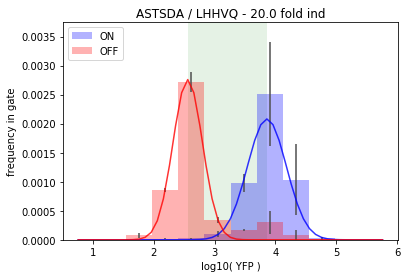

<Figure size 432x288 with 0 Axes>

In [6]:
#example plot (wild type sequence)
s = "TTACACCACGTTCAGGCGAGTACGTCTGATGCT"
print fit_gauss(s,report_error=True, plot=True, mode_norm=0, plot_reps = False )

In [10]:
#sorting all sequences by total frequency (across all bins)
seqs_sorted = sorted(td2i.keys(), key = lambda x: ntfreq[td2i[x]][:49].sum(), reverse = True)

In [11]:
#sequences with WT RR or HK 
wt_rr = []
for s in seqs_sorted:
    if translateDNA(s)[:5] == "LHHVQ":
        wt_rr += [s]
wt_hk = []
for s in seqs_sorted:
    if translateDNA(s)[5:] == "ASTSDA":
        wt_hk += [s]
print len(wt_rr), "WT RR,", len(wt_hk), "WT HK"

3611 WT RR, 2889 WT HK


In [12]:
# # guassian fitting all sequences, saving to CSV

# # can take ~1hr

# starttime = time.time()
# count = 0
# handle = open("gauss_fitted_means_20180430.csv",'w')
# for s in seqs_sorted:
#     try:
#         logu_on,logu_off,perr1, perr2= fit_gauss(s, report_error= True)
#         ind = td2i[s]
#         on_counts = tcounts[ind][1:25].sum()
#         off_counts = tcounts[ind][25:49].sum()
        
#         #guassian mean estimates
#         u_on = 10**logu_on
#         u_off = 10**logu_off
        
#         #stdev of guassian mean estimates (from curve_Fit)
#         std_on = perr1[0] * u_on/logu_on
#         std_off = perr2[0] * u_off/logu_off
        
#         #fold induction
#         fi = u_on/u_off
        
#         handle.write(s+","+translateDNA(s)+","
#                      +str(on_counts)+","+str(off_counts)+","
#                      +str(u_on)+","+str(u_off)+","
#                      +str(std_on)+","+str(std_off)+","+str(fi)+","
#                      +str(perr1[0])+","+str(perr2[0] )+"\n")
#     except RuntimeError:
#         pass
#     count += 1
#     if count%10000 == 0:
#         print round((time.time()-starttime)/60,2),"min\t", str(count),"seqs done"
# print "complete"

In [27]:
#loads CSV from above calculations into panda DataFrame
    #aa = amino acid seq
    #c_on = total counts in gates in ON conditions (10uM Mg)
    #c_off = total counts in gates in OFF conditions (50mM Mg)
    #u_on = guass fit mean in on condition
    #u_off = guass fit mean in off condition
    #std_u_on, std_u_off = std devs of fitted means, spit out of guass fit
    #fi = fold induction
    


#pandas: a great package of datastructures built on numpy (matlab efficient matricies)
#DataFrames: matrices with labeled columns and rows, can hold strings as wells as values
df = pd.read_csv('gauss_fitted_means_20180430.csv',names=['aa','c_on','c_off','u_on','u_off','std_u_on','std_u_off','fi', "error_on", "error_off"])

In [28]:
print len(df), "seqs before error filtering"
df = df[df.error_off + df.error_on < 2]
print len(df), "seqs after error filtering"


79999 seqs before error filtering
13383 seqs after error filtering
